## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to the $\ket{1}$ state by applying a RX-gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [12]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.providers.aer import QasmSimulator

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), you can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a z-gate on the qubit
- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

In [13]:
def perform_action(amp, shots=1, target='1'):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, qasm
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    for ind, angle in enumerate(angles):
        if target == '1':
            qc.rx(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch

        elif target == '+':
            qc.ry(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            qc.h(0) # Transform to hadamard basis before measurement
            
        elif target == '-':
            qc.ry(2 * np.pi * angle, 0)
            qc.z(0)  # Apply Z gate for the minus state
            qc.h(0)
        
        qc.measure(0, 0)  # Measurement
        job = qasm.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key


        #  Calculate reward
        if target == '1':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target in ['+', '-']:
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))

        qc.clear()

    return reward_table

#### Set Hyperparameters for the RL

In [14]:
# Variables to define environment
qc = QuantumCircuit(1, 1)  # Two-level system of interest, 1 qubit
qasm = QasmSimulator()  # Simulation backend (mock quantum computer)

seed = 2364

# Hyperparameters for the agent
n_epochs = 100
batch_size = 50
eta = 0.01  # Learning rate for policy update step

# Policy parameters
mu = nn.Parameter(torch.randn([]) * 0.05)  # Initializing mu with a value drawn from a normal distribution with mean 0, sigma 0.05
sigma = nn.Parameter(torch.tensor(0.05))  # Initializing sigma with a value of 0.05

# Critic parameter (single state-independent baseline b)
b = nn.Parameter(torch.tensor(0.))

In [15]:
target_state = '+'

#### Training

In [16]:
# Create an optimizer for the trainable parameters
optimizer = optim.Adam([mu, sigma, b], lr=eta)
epsilon = 1e-3 # Small offset to avoid sigma = 0
 # Clip the gradients
grad_clip = 0.3

def constrain_mu(value, min_val, max_val):
    return torch.clamp(value, min_val, max_val)

def constrain_sigma(value):
    return torch.relu(value) # Ensures that sigma is non-negative

# Dictionary to keep track of the used parameters
params = {
            'mu': [],
            'sigma': [],
            'reward': [],
            'learning_rate': eta,
            'seed': seed,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
}

### Training loop
for i in tqdm(range(n_epochs)):
    print('\nEPOCH', i+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())

    # Sample action from policy (Gaussian distribution with parameters mu and sigma)
    Normal_distrib = Normal(loc=mu, scale=sigma + epsilon)
    action = Normal_distrib.sample((batch_size,)) # action 

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    reward = perform_action(action, shots=1, target=target_state)
    #reward = perform_action(action, shots=1)
    print("Average Return:", reward.mean().item())

    advantage = torch.tensor(reward, dtype=torch.float32) - b
    
    log_probs = Normal_distrib.log_prob(action)

    actor_loss = -(advantage * log_probs).mean()
    critic_loss = (advantage ** 2).mean()
    critic_loss_coeff = 0.5
    combined_loss = actor_loss + critic_loss_coeff * critic_loss

    # Clear previous gradients
    optimizer.zero_grad() 
    # Backpropagation
    combined_loss.backward()
    # Clip the gradients
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)
    # Apply gradients
    optimizer.step()

    # During training, after each optimizer step:
    with torch.no_grad():
        mu.data = constrain_mu(mu.data, -2., 2.)
        sigma.data = constrain_sigma(sigma.data)
  
    params["mu"].append(mu.item())
    params["sigma"].append(sigma.item())
    params["reward"].append(reward)

  6%|▌         | 6/100 [00:00<00:01, 52.68it/s]


EPOCH 1
Policy parameter
mu = -0.05671527609229088 +- sigma = 0.05000000074505806
baseline 0.0
Average Return: -0.28

EPOCH 2
Policy parameter
mu = -0.04671527445316315 +- sigma = 0.059999994933605194
baseline -0.009999997913837433
Average Return: -0.44

EPOCH 3
Policy parameter
mu = -0.03671196475625038 +- sigma = 0.06496164202690125
baseline -0.01995423063635826
Average Return: -0.12

EPOCH 4
Policy parameter
mu = -0.026726242154836655 +- sigma = 0.07235532253980637
baseline -0.029938841238617897
Average Return: 0.0

EPOCH 5
Policy parameter
mu = -0.01681988127529621 +- sigma = 0.08035973459482193
baseline -0.03963855654001236
Average Return: 0.0

EPOCH 6
Policy parameter
mu = -0.006927601993083954 +- sigma = 0.0823059007525444
baseline -0.04901713877916336
Average Return: -0.08

EPOCH 7
Policy parameter
mu = 0.002969256602227688 +- sigma = 0.08307061344385147
baseline -0.05838710442185402
Average Return: 0.12

EPOCH 8
Policy parameter
mu = 0.01286275964230299 +- sigma = 0.085931383

 20%|██        | 20/100 [00:00<00:01, 63.61it/s]

Average Return: 0.16

EPOCH 13
Policy parameter
mu = 0.06254617869853973 +- sigma = 0.08282017707824707
baseline -0.11145385354757309
Average Return: 0.44

EPOCH 14
Policy parameter
mu = 0.07255832105875015 +- sigma = 0.0797947347164154
baseline -0.11923175305128098
Average Return: 0.12

EPOCH 15
Policy parameter
mu = 0.08253753930330276 +- sigma = 0.07549086213111877
baseline -0.12695075571537018
Average Return: 0.32

EPOCH 16
Policy parameter
mu = 0.09219091385602951 +- sigma = 0.0695905014872551
baseline -0.13462956249713898
Average Return: 0.36

EPOCH 17
Policy parameter
mu = 0.10195372253656387 +- sigma = 0.06433197110891342
baseline -0.14223931729793549
Average Return: 0.52

EPOCH 18
Policy parameter
mu = 0.11156772822141647 +- sigma = 0.06171371042728424
baseline -0.1506287157535553
Average Return: 0.64

EPOCH 19
Policy parameter
mu = 0.12130089849233627 +- sigma = 0.05914613977074623
baseline -0.1587144136428833
Average Return: 0.68

EPOCH 20
Policy parameter
mu = 0.13113667070

 36%|███▌      | 36/100 [00:00<00:00, 69.88it/s]

Average Return: 0.92

EPOCH 28
Policy parameter
mu = 0.20087502896785736 +- sigma = 0.04682835564017296
baseline -0.2243819236755371
Average Return: 0.88

EPOCH 29
Policy parameter
mu = 0.20877312123775482 +- sigma = 0.04293041303753853
baseline -0.23165827989578247
Average Return: 0.96

EPOCH 30
Policy parameter
mu = 0.21493610739707947 +- sigma = 0.04087617248296738
baseline -0.2389543056488037
Average Return: 0.84

EPOCH 31
Policy parameter
mu = 0.2211887389421463 +- sigma = 0.03735007718205452
baseline -0.24601426720619202
Average Return: 0.96

EPOCH 32
Policy parameter
mu = 0.22721390426158905 +- sigma = 0.03240489587187767
baseline -0.2528931498527527
Average Return: 0.92

EPOCH 33
Policy parameter
mu = 0.23304225504398346 +- sigma = 0.026292480528354645
baseline -0.25957900285720825
Average Return: 0.92

EPOCH 34
Policy parameter
mu = 0.23942364752292633 +- sigma = 0.02016337215900421
baseline -0.26638856530189514
Average Return: 0.96

EPOCH 35
Policy parameter
mu = 0.2442434281

 52%|█████▏    | 52/100 [00:00<00:00, 71.68it/s]

Average Return: 1.0

EPOCH 43
Policy parameter
mu = 0.2630949318408966 +- sigma = 0.0
baseline -0.3328849673271179
Average Return: 1.0

EPOCH 44
Policy parameter
mu = 0.2654978632926941 +- sigma = 0.0
baseline -0.33798450231552124
Average Return: 1.0

EPOCH 45
Policy parameter
mu = 0.2688792049884796 +- sigma = 0.0
baseline -0.3427048921585083
Average Return: 1.0

EPOCH 46
Policy parameter
mu = 0.2719649076461792 +- sigma = 0.0
baseline -0.3470454216003418
Average Return: 1.0

EPOCH 47
Policy parameter
mu = 0.27351510524749756 +- sigma = 0.0
baseline -0.3510439395904541
Average Return: 1.0

EPOCH 48
Policy parameter
mu = 0.273870587348938 +- sigma = 0.0
baseline -0.354737251996994
Average Return: 1.0

EPOCH 49
Policy parameter
mu = 0.2729232609272003 +- sigma = 0.0
baseline -0.358184278011322
Average Return: 1.0

EPOCH 50
Policy parameter
mu = 0.2729106545448303 +- sigma = 0.0
baseline -0.3614731729030609
Average Return: 0.96

EPOCH 51
Policy parameter
mu = 0.27162879705429077 +- sigma

 68%|██████▊   | 68/100 [00:00<00:00, 72.51it/s]

Average Return: 0.96

EPOCH 58
Policy parameter
mu = 0.2564663290977478 +- sigma = 0.012007622979581356
baseline -0.38416868448257446
Average Return: 1.0

EPOCH 59
Policy parameter
mu = 0.2567596137523651 +- sigma = 0.012349097058176994
baseline -0.3879580497741699
Average Return: 1.0

EPOCH 60
Policy parameter
mu = 0.258158802986145 +- sigma = 0.013463420793414116
baseline -0.3916175663471222
Average Return: 1.0

EPOCH 61
Policy parameter
mu = 0.2597177028656006 +- sigma = 0.016013488173484802
baseline -0.3952328562736511
Average Return: 1.0

EPOCH 62
Policy parameter
mu = 0.2617759108543396 +- sigma = 0.016906268894672394
baseline -0.39877480268478394
Average Return: 1.0

EPOCH 63
Policy parameter
mu = 0.2647657096385956 +- sigma = 0.016920099034905434
baseline -0.40247049927711487
Average Return: 1.0

EPOCH 64
Policy parameter
mu = 0.26840776205062866 +- sigma = 0.018040738999843597
baseline -0.4059291481971741
Average Return: 1.0

EPOCH 65
Policy parameter
mu = 0.27287957072257996 

 84%|████████▍ | 84/100 [00:01<00:00, 72.60it/s]

Average Return: 0.92

EPOCH 73
Policy parameter
mu = 0.2908213138580322 +- sigma = 0.014507682994008064
baseline -0.4445430338382721
Average Return: 0.92

EPOCH 74
Policy parameter
mu = 0.2955516278743744 +- sigma = 0.013184810988605022
baseline -0.4500078558921814
Average Return: 1.0

EPOCH 75
Policy parameter
mu = 0.2985309660434723 +- sigma = 0.012380730360746384
baseline -0.45585209131240845
Average Return: 0.88

EPOCH 76
Policy parameter
mu = 0.3004171848297119 +- sigma = 0.010404855012893677
baseline -0.4615854024887085
Average Return: 0.96

EPOCH 77
Policy parameter
mu = 0.3022603988647461 +- sigma = 0.00708683580160141
baseline -0.4672558307647705
Average Return: 0.96

EPOCH 78
Policy parameter
mu = 0.30275020003318787 +- sigma = 0.0033409632742404938
baseline -0.4726389944553375
Average Return: 0.96

EPOCH 79
Policy parameter
mu = 0.3040613830089569 +- sigma = 0.0
baseline -0.47778740525245667
Average Return: 1.0

EPOCH 80
Policy parameter
mu = 0.30430400371551514 +- sigma = 0

100%|██████████| 100/100 [00:01<00:00, 70.46it/s]

Average Return: 0.92

EPOCH 88
Policy parameter
mu = 0.31843116879463196 +- sigma = 0.0
baseline -0.5095471739768982
Average Return: 0.76

EPOCH 89
Policy parameter
mu = 0.32309362292289734 +- sigma = 0.0
baseline -0.5119142532348633
Average Return: 0.88

EPOCH 90
Policy parameter
mu = 0.3283550441265106 +- sigma = 0.0
baseline -0.5156319737434387
Average Return: 0.88

EPOCH 91
Policy parameter
mu = 0.3335321247577667 +- sigma = 0.0
baseline -0.5190824270248413
Average Return: 0.84

EPOCH 92
Policy parameter
mu = 0.33804041147232056 +- sigma = 0.0
baseline -0.5222719311714172
Average Return: 0.92

EPOCH 93
Policy parameter
mu = 0.34324657917022705 +- sigma = 0.0
baseline -0.5252158641815186
Average Return: 0.84

EPOCH 94
Policy parameter
mu = 0.3492717742919922 +- sigma = 0.0
baseline -0.527935266494751
Average Return: 0.92

EPOCH 95
Policy parameter
mu = 0.35555294156074524 +- sigma = 0.0
baseline -0.530451238155365
Average Return: 0.8

EPOCH 96
Policy parameter
mu = 0.362523883581161

#### Visualization

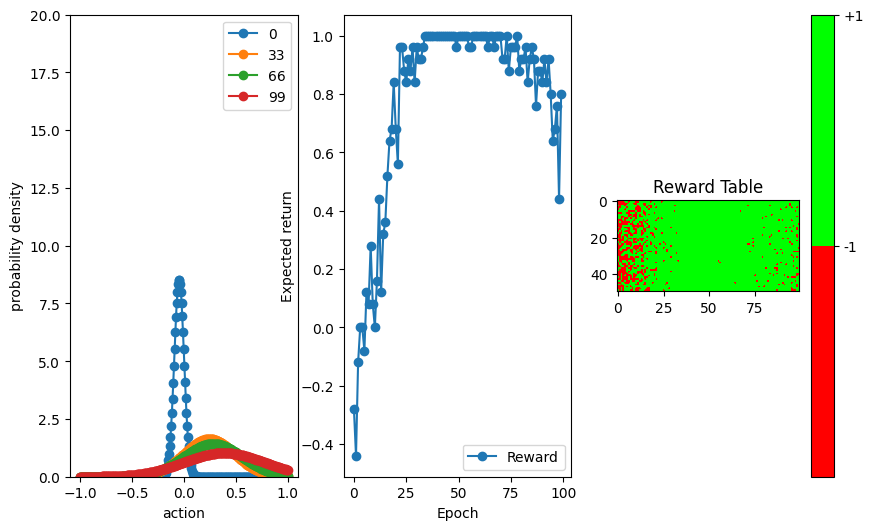

In [17]:
x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, n_epochs//25, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["mu"][i], scale=np.abs(params["mu"][i])), '-o', label=f'{i}')

ax1.set_xlabel("action")
ax1.set_ylabel("probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["reward"], axis=1), '-o', label='Reward')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Expected return")
ax2.legend()
ax1.legend()

rewards = np.array(params['reward']).transpose()
# Create a custom colormap
colors = [(1, 0, 0), (0, 1, 0)]  # R -> G
cmap_name = 'custom_red_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Dummy data and imshow for ax3
cax = ax3.imshow(rewards, cmap=cm)
ax3.set_title("Reward Table")

# Add colorbar to ax3
cbar = fig.colorbar(cax, ax=ax3, ticks=[0, 1])
cbar.ax.set_yticklabels(['-1', '+1'])

plt.show()